# Download Antarctic datasets
The module `antarctic_plots.fetch` provides an easy way to download, pre-process and store common datasets related to Antarctica. More datasets will be added, so check the changelogs for new datasets or submit a issue on github to request adding new datasets.

All the functions in the `antarctic_plots.fetch` module use the python package Pooch to download and store the data. Several of the functions include pre-processing to grid and reproject the data to Polar Stereographic. The first call to a function will download and preprocess the data, which may take some time, but subsequent calls to the same function will just fetch the already processed and downloaded data. These datasets will be stored by default in your following local file:
* Mac: `~/Library/Caches/pooch`
* Unix: `~/.cache/pooch` or the value of the XDG_CACHE_HOME environment variable, if defined.
* Windows: `C:\Users\<user>\AppData\Local\pooch\pooch\Cache`

In [1]:
%%capture
%load_ext autoreload
%autoreload 2
from antarctic_plots import fetch, regions, maps, utils
import pyogrio

# set Python's logging level to get information
import logging
logging.getLogger().setLevel(logging.INFO)

Here is a list of all the currently available datasets to fetch:

In [8]:
print("\n".join(fetch.get_fetches()))c

basal_melt
basement
bedmachine
bedmap2
bedmap_points
crustal_thickness
deepbedmap
etopo
geoid
geomap
ghf
gia
gravity
groundingline
ibcso
ibcso_coverage
ice_vel
imagery
magnetics
mass_change
measures_boundaries
modis_moa
moho
rema
rosetta_gravity
rosetta_magnetics
sediment_thickness


Download and plot BedMap thickness data, the default will return a grid of the full antarctic region, at 1km resolution.


grid spacing: 1000.0 m
grid region: (-3333000.0, 3333000.0, -3333000.0, 3333000.0)
grid zmin: 0.0
grid zmax: 4621.0
grid registration: g


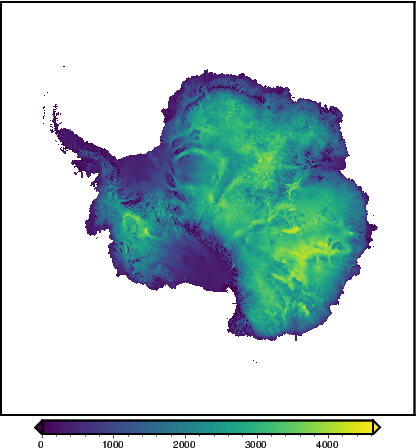

In [9]:
grid = fetch.bedmap2(
    layer="thickness",
    verbose="q",
)
info = utils.get_grid_info(grid, print_info=True)
maps.plot_grd(grid)

Resample the grid by provide 1 or all of the following:
* region: give a subset region. See the modeule antarctic_plots.regions for examples.
* spacing: supply a new grid spacing in meters.
* registration: choose between 'p' for pixel and 'g' for gridline

grid spacing: 20000.0 m
grid region: (-1540000.0, -500000.0, 80000.0, 1200000.0)
grid zmin: 13.1436920166
grid zmax: 3208.5925293
grid registration: g


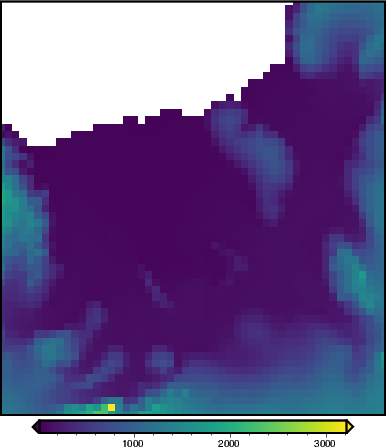

In [10]:
grid = fetch.bedmap2(
    layer="surface",
    region=regions.ronne_filchner_ice_shelf,
    spacing=20e3,  # 20km
    registration="g",
    verbose="q",
)
info = utils.get_grid_info(grid, print_info=True)
maps.plot_grd(grid)

Apply common corrections, such as calculating the ice base (surface - thickness) and converting the grid elevation from a geoid to an ellipsoid reference

grid spacing: 1000.0 m
grid region: (-3333000.0, 3333000.0, -3333000.0, 3333000.0)
grid zmin: -2782.72192383
grid zmax: 3953.65917969
grid registration: g


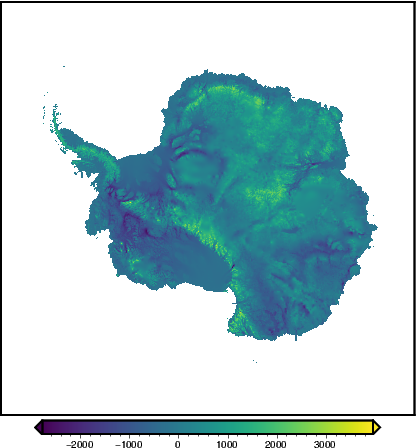

In [11]:
grid = fetch.bedmap2(
    layer="icebase",
    reference="ellipsoid",
    verbose="q",
)
info = utils.get_grid_info(grid, print_info=True)
maps.plot_grd(grid)

`Fetch` also allows for downloading datasets from [NSIDC](https://nsidc.org/home), which requires an [Earthdata login](https://urs.earthdata.nasa.gov/home). Calling `fetch` on one of these datasets will either 
1) look for a username and password which have been set in your environment variables as `EARTHDATA_USERNAME` and `EARTHDATA_PASSWORD` or
2) look in a `.env` file in this repository with the above two variables set or,
3) prompts to enter your username and password will appear. 

Note: you may need to restart your computer for new environment variables to be registered.

grid spacing: 500.0 m
grid region: (-2600000.0, -1200000.0, 170000.0, 1800000.0)
grid zmin: 0.0
grid zmax: 3088.77832031
grid registration: g


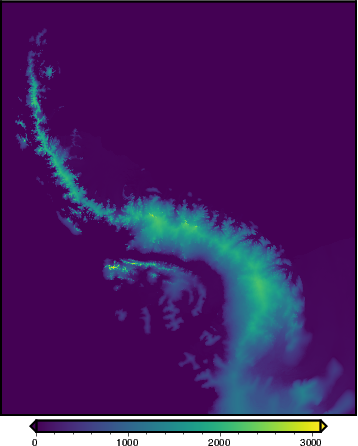

In [13]:
grid = fetch.bedmachine(
    layer="surface",
    region=regions.antarctic_peninsula,
    verbose="q",
)
info = utils.get_grid_info(grid, print_info=True)
maps.plot_grd(grid)

INFO:root:using preprocessed 5km grid since spacing is > 5km


INFO:root:spacing larger than original, filtering and resampling


grid spacing: 10000.0 m
grid region: (-1550000.0, -500000.0, 80000.0, 1200000.0)
grid zmin: 0.179185196757
grid zmax: 1568.64538574
grid registration: g


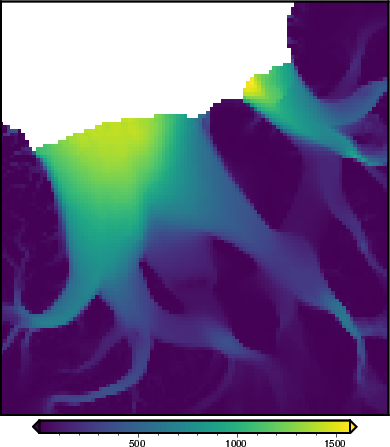

In [10]:
grid = fetch.ice_vel(
    region=regions.ronne_filchner_ice_shelf,
    verbose="q",
    spacing=10e3,
)
info = utils.get_grid_info(grid, print_info=True)
maps.plot_grd(grid)

Warning 1: The definition of geographic CRS EPSG:4326 got from GeoTIFF keys is not the same as the one from the EPSG registry, which may cause issues during reprojection operations. Set GTIFF_SRS_SOURCE configuration option to EPSG to use official parameters (overriding the ones from GeoTIFF keys), or to GEOKEYS to use custom values from GeoTIFF keys and drop the EPSG code.
Warning 1: The definition of geographic CRS EPSG:4326 got from GeoTIFF keys is not the same as the one from the EPSG registry, which may cause issues during reprojection operations. Set GTIFF_SRS_SOURCE configuration option to EPSG to use official parameters (overriding the ones from GeoTIFF keys), or to GEOKEYS to use custom values from GeoTIFF keys and drop the EPSG code.
Warning 1: The definition of geographic CRS EPSG:4326 got from GeoTIFF keys is not the same as the one from the EPSG registry, which may cause issues during reprojection operations. Set GTIFF_SRS_SOURCE configuration option to EPSG to use officia

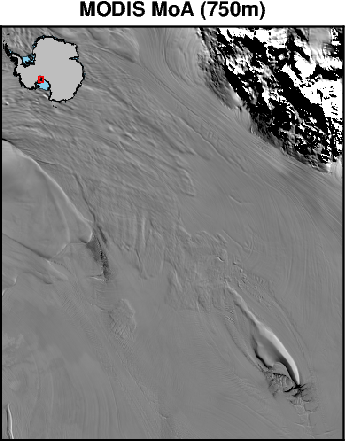

In [5]:
moa = fetch.modis_moa(version="750m")
maps.plot_grd(
    moa,
    cmap="gray",
    image=True,
    region=regions.crary_ice_rise,
    title="MODIS MoA (750m)",
    inset=True,
)

Get the groundingline and coastline data and visualize the classifications

In [2]:
# load the grounding and coast line database
shp = pyogrio.read_dataframe(fetch.groundingline())

# see the options for subsetting
shp.Id_text.unique()

array(['Ice shelf', 'Isolated island', 'Ice rise or connected island',
       'Grounded ice or land'], dtype=object)

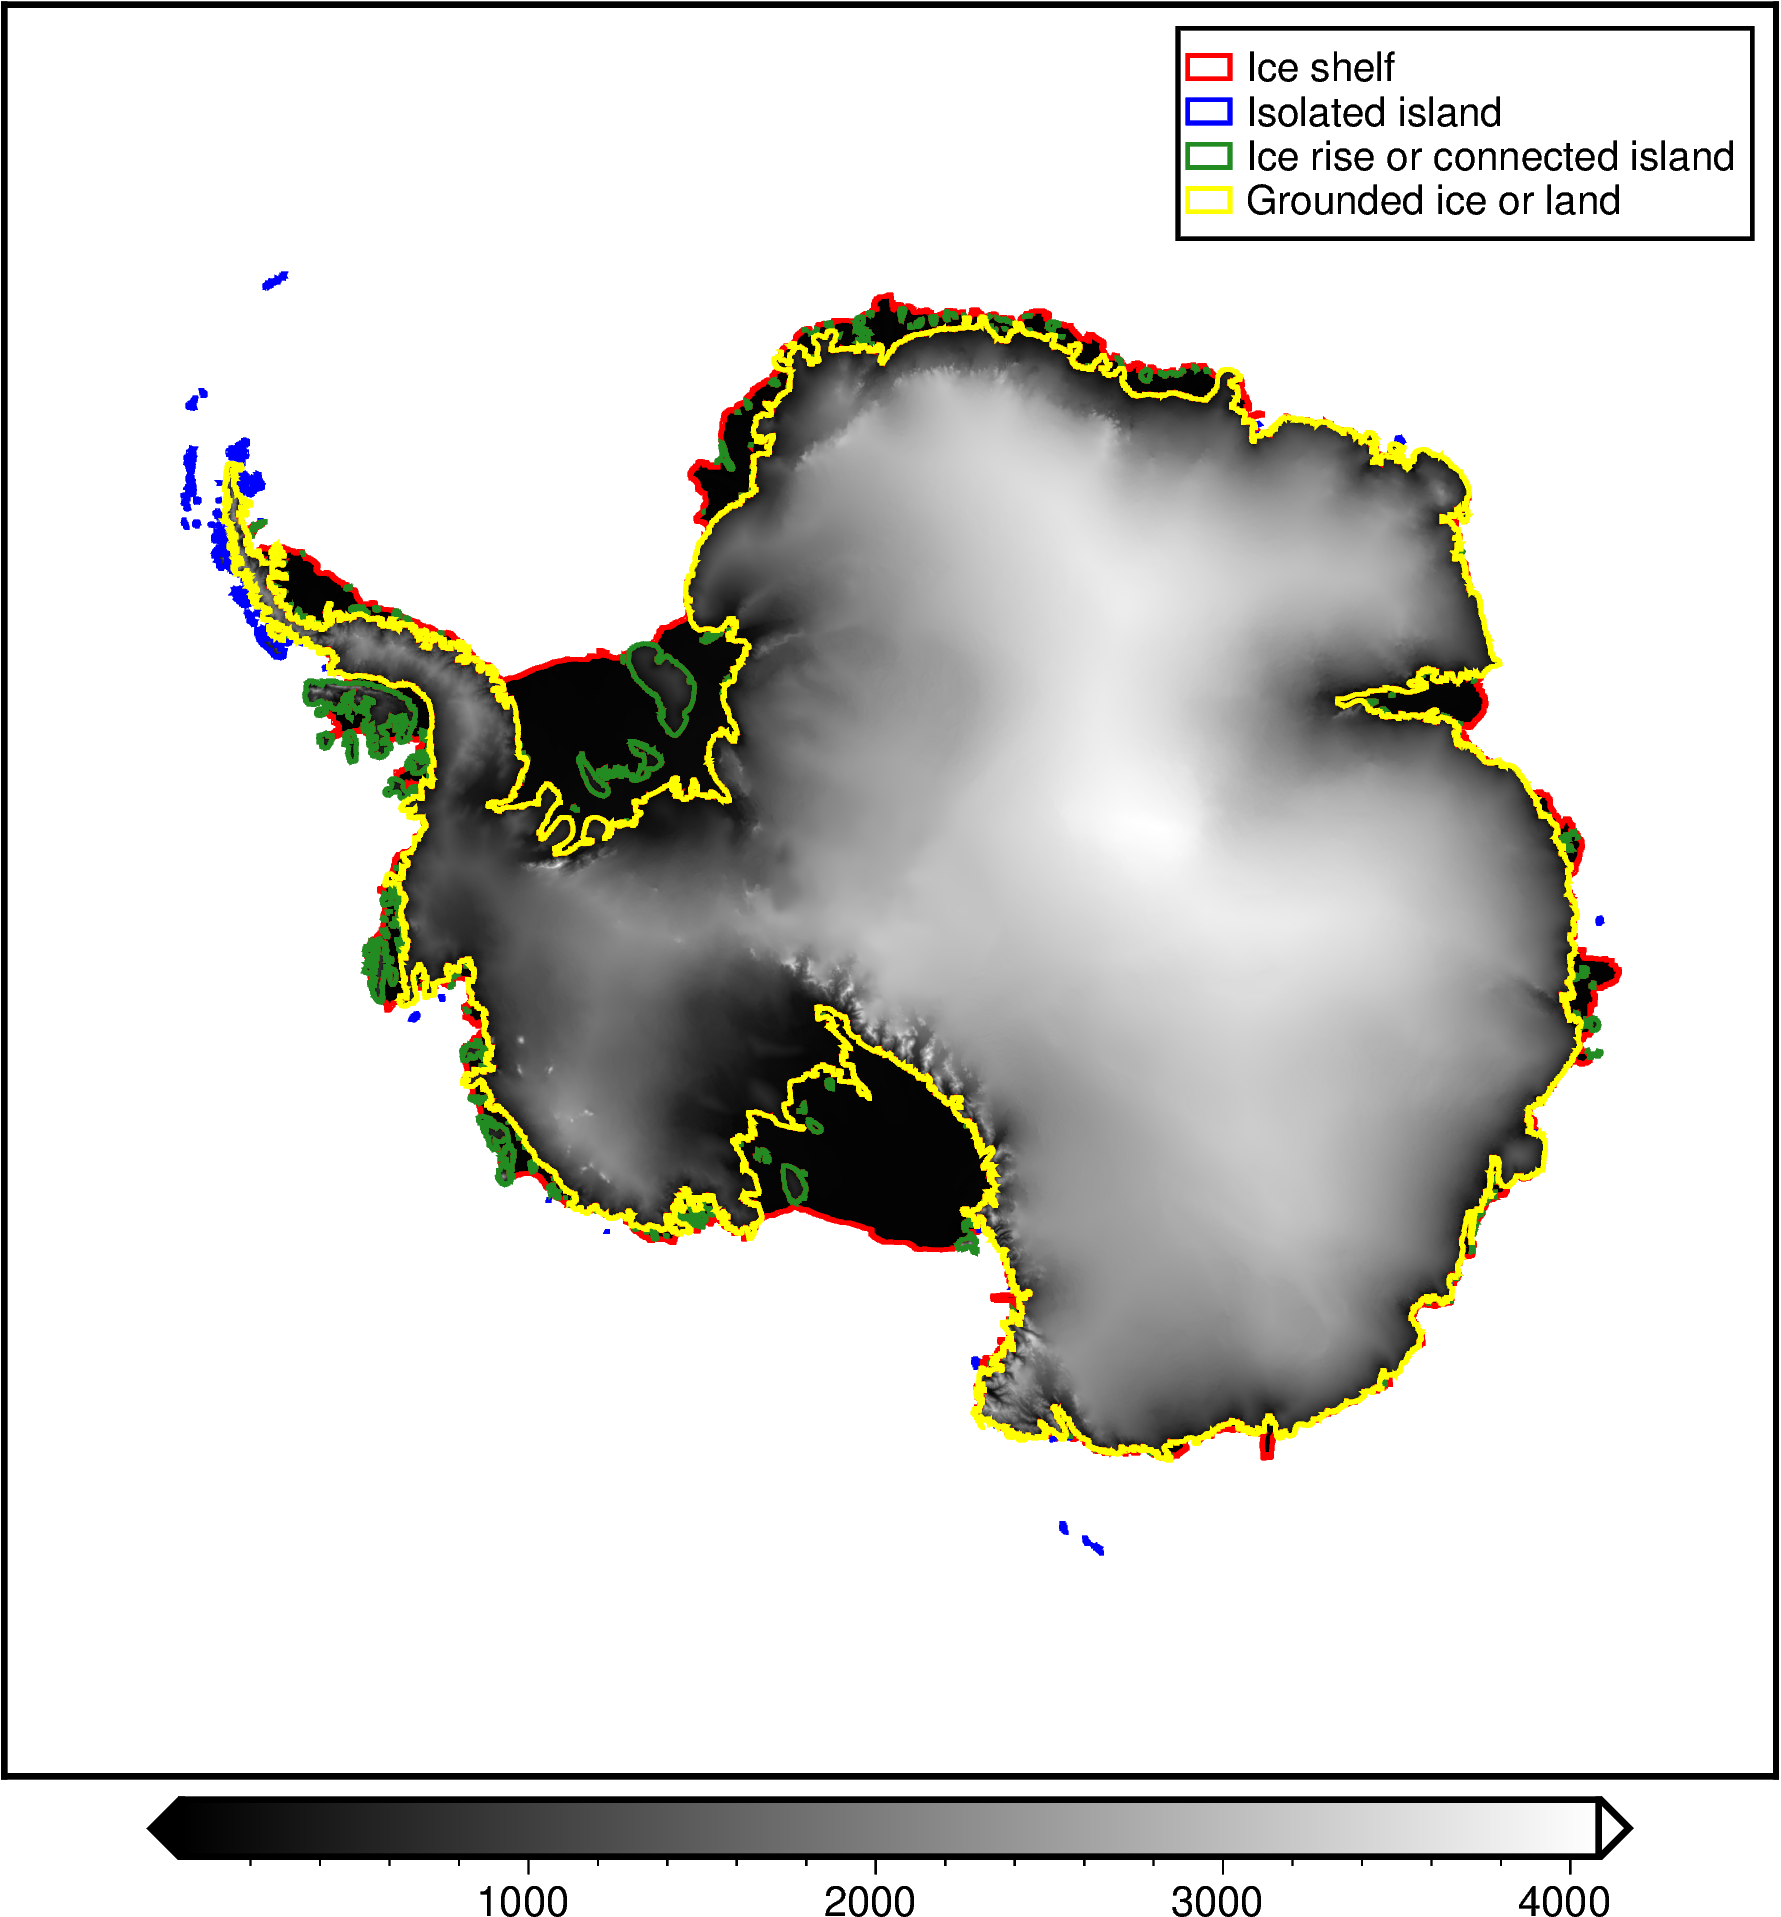

In [5]:
# plot a quick basemap
# fig = maps.plot_grd(fetch.bedmap2(layer="surface"), cmap="gray")

# add the classifications of grounding/coast line types to the map
colors = ["red", "blue", "forestgreen", "yellow"]
for i, j in enumerate(shp.Id_text.unique()):
    fig.plot(
        shp[shp.Id_text == j],
        pen=f"1p,{colors[i]}",
        label=j,
    )

fig.legend()
fig.show()